In [41]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib
import pickle
from numpy import genfromtxt
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing as mp
import scipy.io
from tqdm import tqdm_notebook as tqdm
import h5py
import math
from scipy.ndimage.filters import gaussian_filter1d

In [42]:
import sys
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.hypothesis_tests.two_sample_test.power_dimension_single import power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [39]:
simulations = {'w_shape': (w_sim, 7)}
               #, 'fourth_root': (root_sim, 11), 
               #'bernoulli': (ubern_sim, 9)}
    #'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3), 'step': (step_sim, 5), 
               #'spiral': (spiral_sim, 8), 'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 
               #'bernoulli': (ubern_sim, 9), 'circle': (circle_sim, 16), 'ellipse': (circle_sim, 17),
               #'two_parabolas': (two_parab_sim, 15), 'fourth_root': (root_sim, 11)}
#{'multi_indept': (multi_indep_sim, 20), 'joint_normal': (joint_sim, 4), 'multi_noise': (multi_noise_sim, 19)}
#{'linear': (linear_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3), 'step': (step_sim, 5), 
               #'spiral': (spiral_sim, 8), 'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 'bernoulli': (ubern_sim, 9)}
#{'log': (log_sim, 10)} at 1.2
#{'multi_indept': (multi_indep_sim, 20), 'joint_normal': (joint_sim, 4), 'multi_noise': (multi_noise_sim, 19), } at 0.6
#{'sine_4pi': (sin_sim, 12), 'sine_16pi': (sin_sim, 13), 
              #'diamond': (square_sim, 18),  
              # 'square': (square_sim, 14)} at 0.5
#{'step': (step_sim, 5), 'spiral': (spiral_sim, 8), 'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 
               #'bernoulli': (ubern_sim, 9), 'linear': (linea_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3)}

In [40]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.2)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [41]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [42]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
7 mantel
7 biased
7 unbiased
7 mantel finished
7 pearson
7 pearson finished
7 rv
7 biased finished
7 cca
7 unbiased finished
7 rv finished
7 cca finished
CPU times: user 123 ms, sys: 58.8 ms, total: 181 ms
Wall time: 2min 52s


In [43]:
def plot_all_curves():
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
        
        
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14,12)) 
    simulation_type=0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']
            #mgc_power = np.genfromtxt('{}_mgc_angle_matlab_new.csv'.format(simulation_type), delimiter=',')

            for test in tests:
                power = np.genfromtxt('{}_{}_dimension_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                x_axis = [1,2,3,4,5,6,7,8,9,10]
                col.plot(x_axis, power, label=test)
                col.set_ylim(-0.25, 1.25)
                col.set_yticks([-0.25, 0, 0.25, 0.50, 0.75, 1.00])
                col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    fig.suptitle('Power of Changing Dimension')
    plt.savefig('power_curves_dimension', bbox_inches='tight')

In [43]:
def plot_all_curves():
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
    plot_titles = ['Linear', 'Exponential', 'Cubic','Joint Normal', 'Step', 'Quadratic', 'W-Shaped', 'Spiral', 
                         'Uncorrelated\nBernoulli', 'Logarithmic', 'Fourth Root', 'Sine (4$\pi$)',
                       'Sine (16$\pi$)', 'Square', 'Two Parabolas', 'Circle', 'Ellipse', 'Diamond', 'Multiplicative\nNoise',
                        'Multimodal\nIndependence']
        
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']
            test_names = ['MGC', 'Unbiased Dcorr', 'Biased Dcorr', 'Mantel', 'Pearson', 'RV', 'CCA']
            #dir_name = '../mgcpy/benchmarks/python_power_curves_dimensions/'
            #mgc_power = np.genfromtxt(dir_name + '{}_mgc_dimensions.csv'.format(simulation_type), delimiter=',')

            count = 0;
            for test in tests:
                mgc_power = np.genfromtxt('{}_mgc_dimension_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                power = np.genfromtxt('{}_{}_dimension_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                power = power - mgc_power
                x_axis = [1,2,3,4,5,6,7,8,9,10]
                power_new = gaussian_filter1d(power, sigma=0.75)
                if test == 'mgc':
                    col.plot(x_axis, power_new, label=test_names[count], lw=5, color='red')
                elif test == 'fast_mgc':
                    col.plot(x_axis, power_new, label=test_names[count], lw=5, color='red', linestyle=':')
                elif test == 'unbiased':
                    col.plot(x_axis, power_new, label=test_names[count], lw=3, color='blue')
                elif test == 'fast_unbiased':
                    col.plot(x_axis, power_new, label=test_names[count], lw=3, color='blue', linestyle=':')
                else:
                    col.plot(x_axis, power_new, label=test_names[count], lw=3)
                col.set_ylim(-1.05, 1.05)
                if simulation_type == 16 or simulation_type == 17 or simulation_type == 18 or simulation_type == 19 or simulation_type == 20:
                    col.set_xticks([1, 10])
                else:
                    col.set_xticks([])
                if simulation_type == 1 or simulation_type == 6 or simulation_type == 11 or simulation_type == 16:
                    col.set_yticks([-1, 0, 1])
                else:
                    col.set_yticks([])
                col.tick_params(labelsize=35)
                for tick in col.get_xticklabels():
                    tick.set_fontname("Arial")
                for tick in col.get_yticklabels():
                    tick.set_fontname("Arial")
                col.set_title(plot_titles[simulation_type-1], fontname="Arial", fontsize=35)
                count += 1;
                #file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure, ncol=5, loc='upper center',fontsize=35)
    leg.get_frame().set_linewidth(0.0)
    plt.subplots_adjust(hspace=.65)
    plt.savefig('relative_two_sample_power_vs_dimension.pdf', bbox_inches='tight')
    #if which_type == 'dimension':
        #fig.suptitle('Power of Independence Tests for Increasing Dimensions', fontsize=30)
        # plt.savefig('../../../../Desktop/Neuro Data Design/power_curves_dimensions')
    #else:
        #fig.suptitle('Power of Independence Tests for Increasing Sample Size', fontsize=30)
        # plt.savefig('../../../../Desktop/Neuro Data Design/power_curves_sample_size')

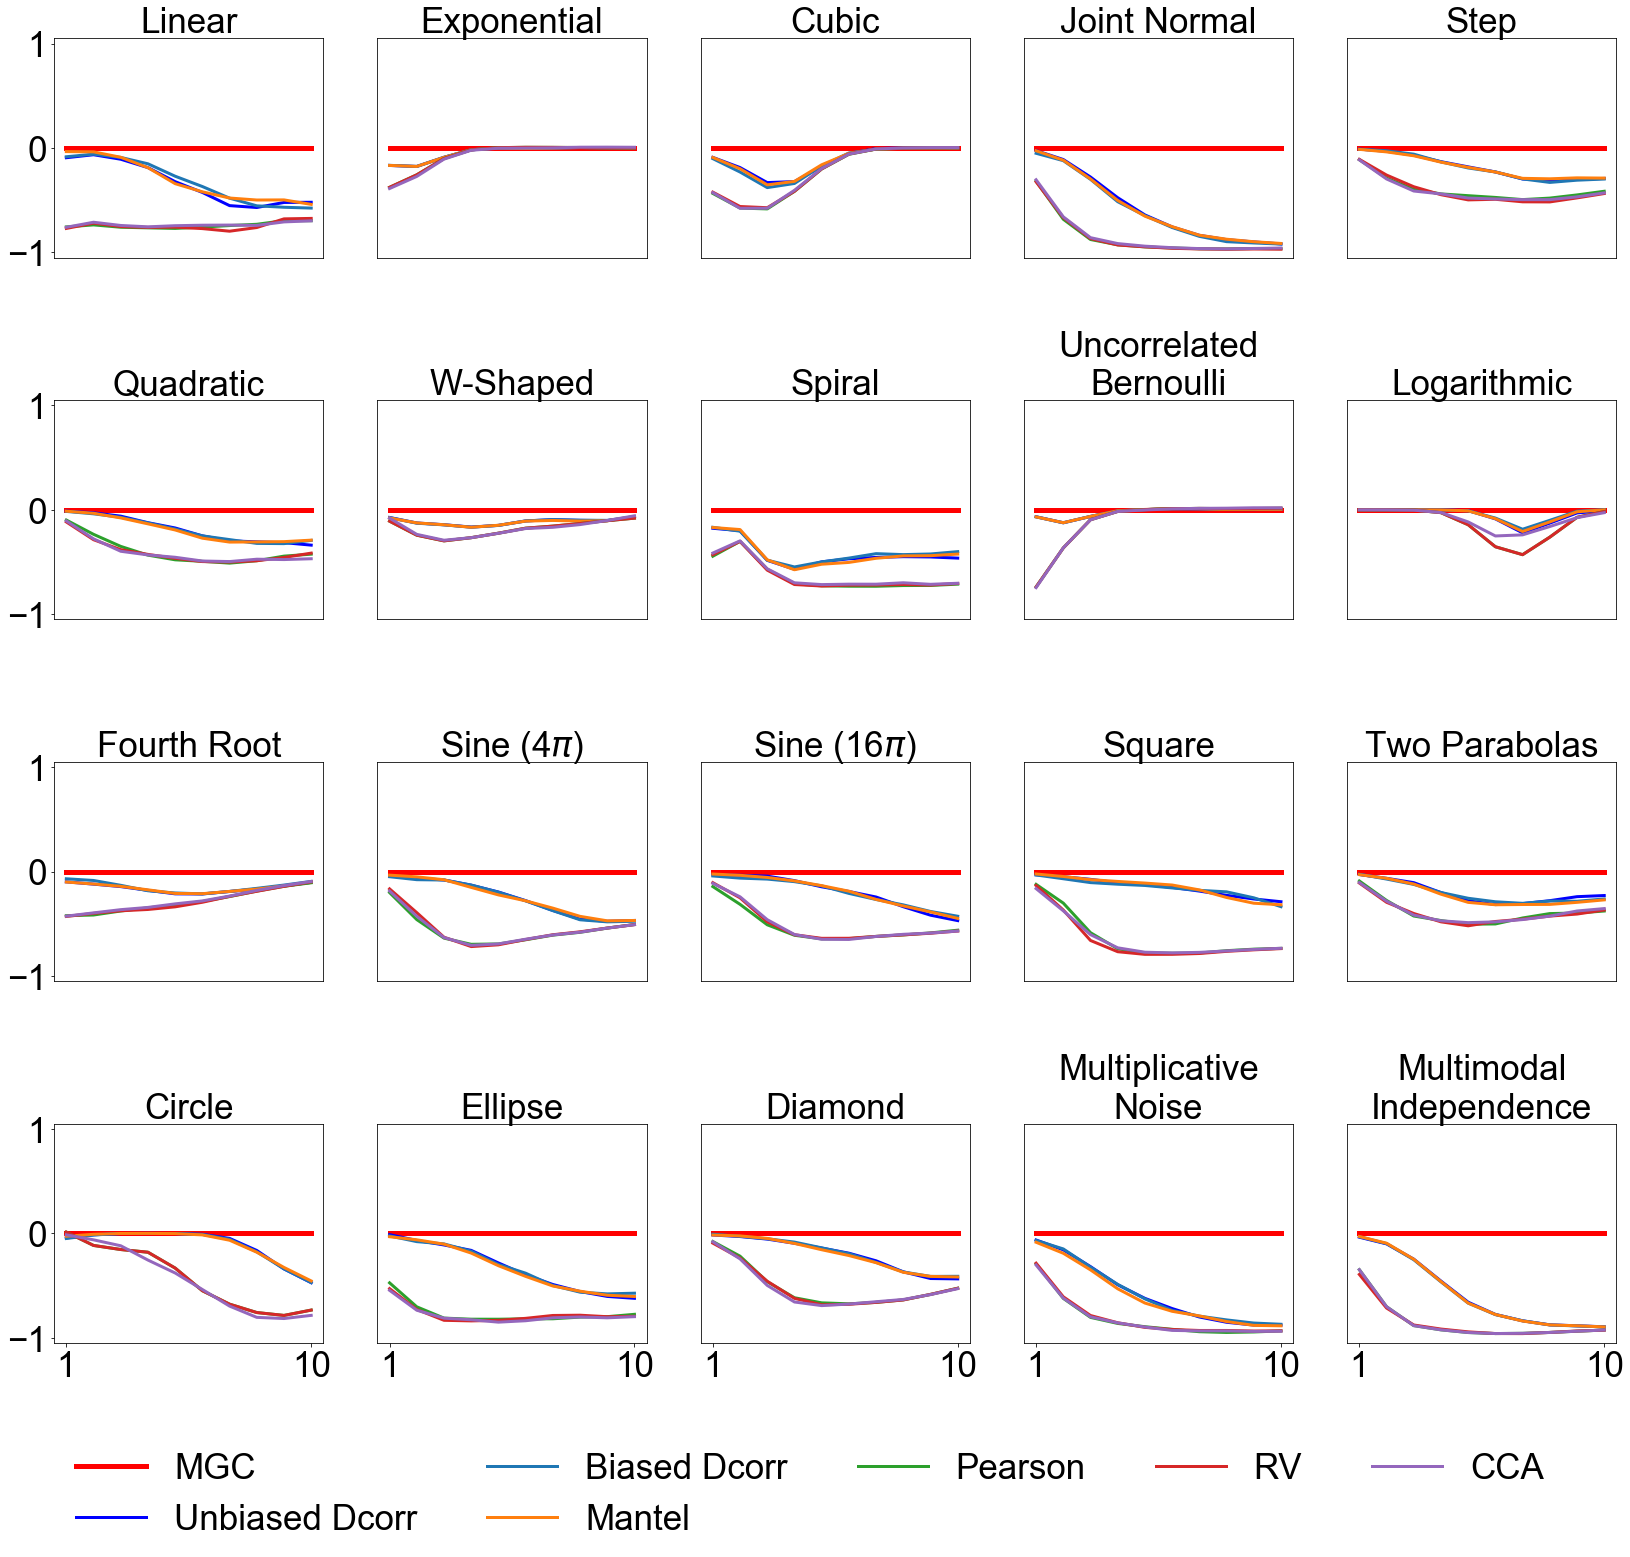

In [44]:
plot_all_curves()

In [ ]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.1)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [ ]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [ ]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

In [ ]:
plot_all_curves()

In [ ]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.2)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [ ]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [ ]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

In [ ]:
plot_all_curves()

In [ ]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.25)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [ ]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [ ]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

In [ ]:
plot_all_curves()

In [ ]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.6)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [ ]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [ ]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

In [ ]:
plot_all_curves()

In [ ]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.8)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [ ]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [ ]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

In [ ]:
plot_all_curves()

In [ ]:
simulations = {'linear': (linear_sim, 1), 'cubic': (cub_sim, 3), 'step': (step_sim, 5), 'ellipse': (circle_sim, 17),
               'quadratic': (quad_sim, 6), 'two_parabolas': (two_parab_sim, 15), 'w_shape': (w_sim, 7), 
               'spiral': (spiral_sim, 8)}

In [ ]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.2)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [ ]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [ ]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

In [ ]:
plot_all_curves()

In [ ]:
simulations = {'circle': (circle_sim, 16)}

In [ ]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.25)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [ ]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [ ]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

In [ ]:
plot_all_curves()

In [51]:
simulations = {'step': (step_sim, 5), 'quadratic': (quad_sim, 6), 'two_parabolas': (two_parab_sim, 15)}

In [52]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.3)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [53]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [54]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
5 mantel
5 unbiased
5 pearson
5 pearson finished
5 rv
5 rv finished
5 cca
5 mantel finished
5 mgc
5 cca finished
6 unbiased
5 unbiased finished
5 biased
6 unbiased finished
6 biased
5 biased finished
6 mgc
6 biased finished
6 mantel
6 mantel finished
6 rv
6 rv finished
6 cca
6 cca finished
15 unbiased
15 unbiased finished
15 biased
15 biased finished
15 mantel
15 mantel finished
15 mgc
5 mgc finished
15 pearson
15 pearson finished
15 rv
15 rv finished
15 cca
15 cca finished
6 mgc finished
6 pearson
6 pearson finished
15 mgc finished
CPU times: user 8.82 s, sys: 2.04 s, total: 10.9 s
Wall time: 3h 44min 16s


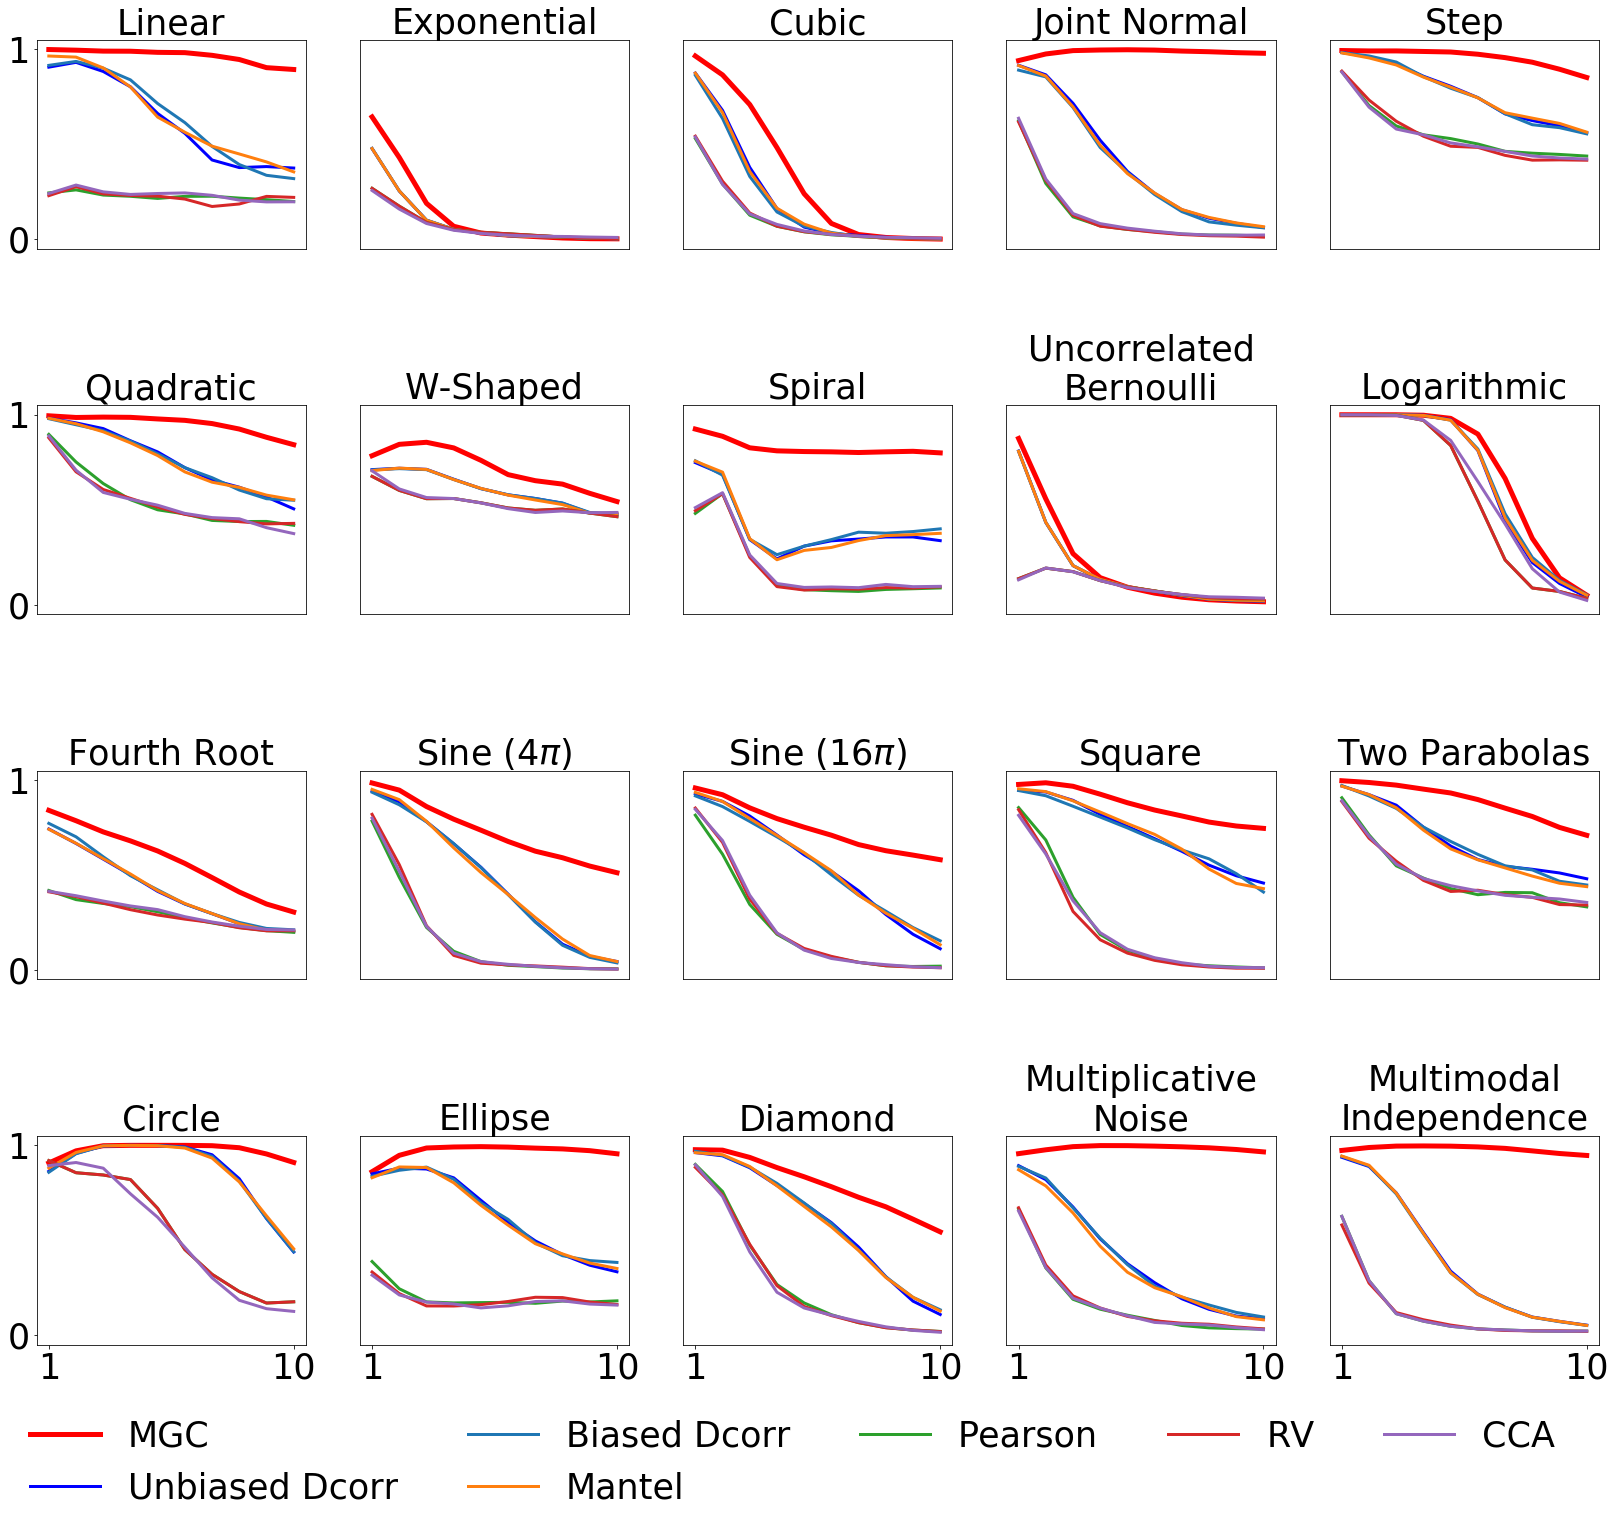

In [55]:
plot_all_curves()